In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from feature_engine import encoding as ce
from graphs import Linear_Reg_Diagnostic as lrd
from sklearn.preprocessing import StandardScaler


pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [2]:
# Import data
file_pw = "../data/insurance.csv"

df = pd.read_csv(file_pw)

# Exploratory Data Analysis

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])

Number of rows:  1338
Number of columns:  7


In [5]:
missing_count = df.isnull().sum().sum()
print("Number of missing entries in the insurance data: ", missing_count)

Number of missing entries in the insurance data:  0


### Variable types

In [6]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Encoding of 'sex', 'smoker' and 'region' is necessary. 

## Distribution and statistic of target column

count     1338.00
mean     13270.42
std      12110.01
min       1121.87
25%       4740.29
50%       9382.03
75%      16639.91
max      63770.43
Name: charges, dtype: float64

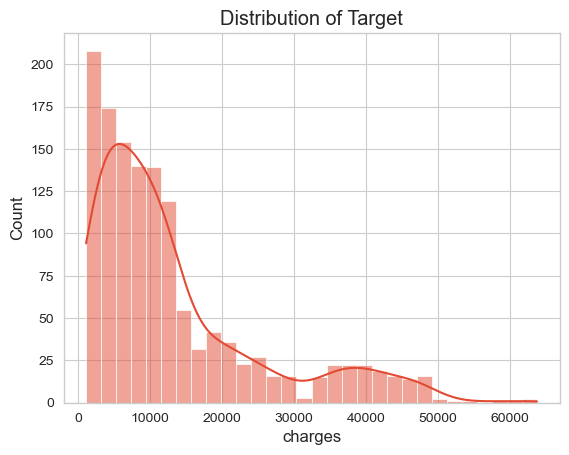

In [7]:
sns.set_style('whitegrid')
charges = sns.histplot(df['charges'],  kde=True)
charges.set(title = "Distribution of Target")
df['charges'].describe().round(2)

Target's distribution is higly right-skewed (median < mean) with mean billing costs of US$ 13,270 and standard deviation of US$ 12,110. It seems that we have a few outliers that may need attention.


## Categorical Features

In [8]:
# List of categorical variables
cat = df.select_dtypes(include=['object', 'bool']).columns.tolist()

### Data entries by category

In [9]:
def plot_label_count(df, categorical_columns):
    size = math.ceil(df[categorical_columns].shape[1]** (1/2))
    fig = plt.figure()
    fig.suptitle('Insured people per category'.title())

    for i, col in enumerate(df[categorical_columns].columns):
        fig.add_subplot(size, size, i + 1)
        df[col].value_counts().plot(kind="bar", ax=plt.gca(),rot=0)
        plt.title(f"{col} variable".title(), fontsize=10)

    fig.tight_layout()

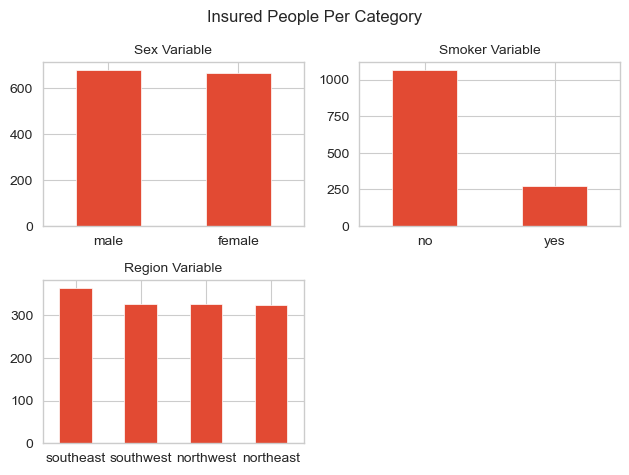

In [10]:
plot_label_count(df, cat)

The sample is well balanced between classes of gender and location, but has mostly non-smokers. 

In [11]:
def target_distribution(df, categorical_columns):
    size = math.ceil(df[categorical_columns].shape[1]** (1/2))
    fig = plt.figure()
    fig.suptitle('Charges distribution per category'.title())

    for i, col in enumerate(df[categorical_columns].columns):
        fig.add_subplot(size, size, i + 1)
        sns.boxplot(x=col, y="charges", data=df,palette='rainbow')
        plt.title(f"{col} variable".title(), fontsize=11)
        plt.xlabel("")
        plt.xticks(rotation=30)
        plt.ylabel("")

    fig.tight_layout()



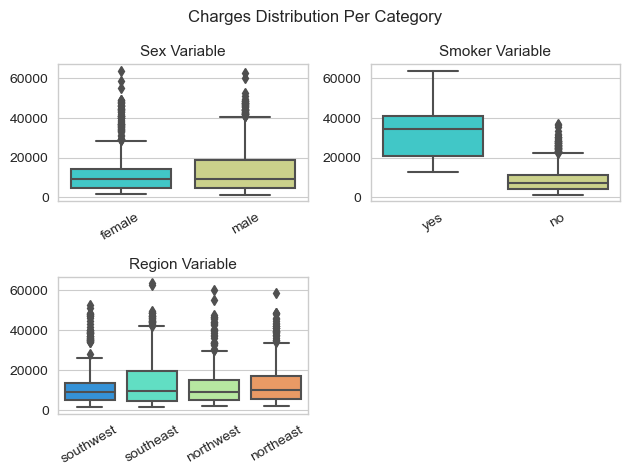

In [12]:
target_distribution(df, cat)

- Male's costs are slightly higher than female's. 
- Smokers tends to represent higher impact on insurance charges.
- Southeast region presents the wider distribution of charges between all. 
- ~10% of data is above U$ 30k.

## Numerical Features

In [13]:
num = [x for x in df.drop(columns='charges').columns if x not in cat]

### Distribution

In [14]:
def plot_distributions(df, numerical_columns):
    f, ax = plt.subplots(ncols=len(numerical_columns), figsize=(17,4))
    f.suptitle("data distribution".title())

    col = 0

    for i, column in enumerate(numerical_columns):   
        g = sns.histplot(df[column], kde=True, ax=ax[col])
        g.set_title(f"Mean={round(df[column].mean(), 2)} - Mode={round(df[column].median(), 2)} - Standard Dev.={round(df[column].std(), 2)}", fontsize=10)
        col += 1

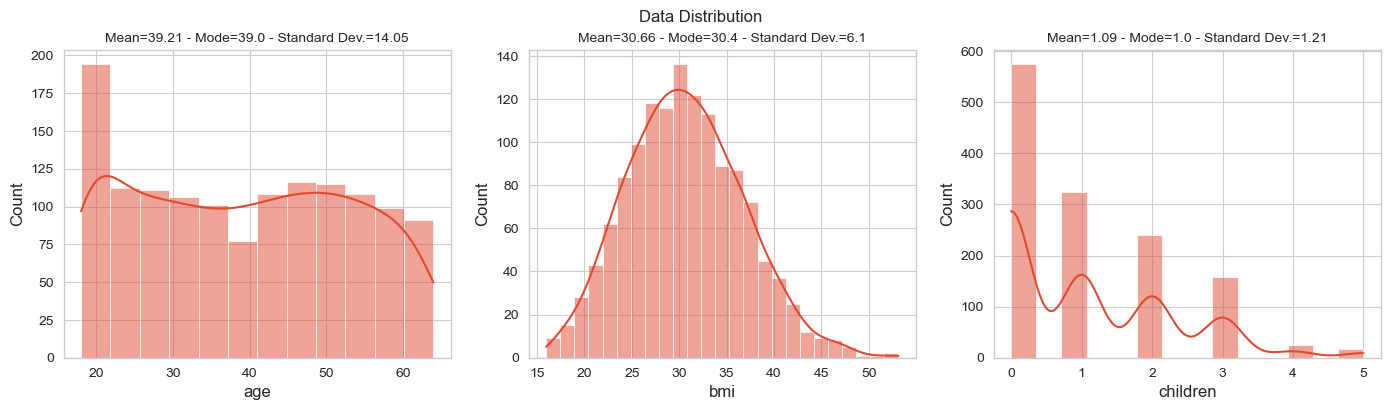

In [15]:
plot_distributions(df, num)

- The age distribution is close to uniform. There is a peak in the sample of people in their 20s.
- Body mass index follows approximately a gaussian distribution. 95% of registers are between 18.46 and 42.86.
- Quantity of children is higly right skewed, which makes sense since birth rate has been falling over time.

### Correlation and Collinearity

In [16]:
def plot_correlations(df):
    corr = df.corr()
    f, ax = plt.subplots(figsize=(6,3))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    htmp = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, mask = mask, cmap=cmap)
    htmp.set_title('Correlation Heatmap', fontsize=10)
    plt.show()

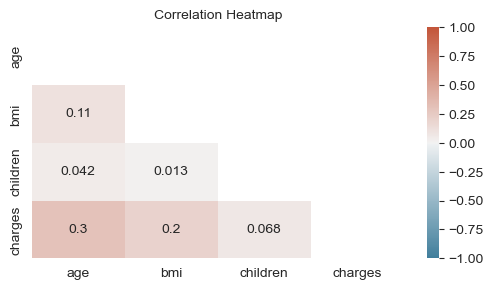

In [17]:
plot_correlations(df)

- Age and bmi are somewhat correlated and impacts charges the most.

In [18]:
def plot_relationship(df, numerical_columns, target_var):
    f, ax = plt.subplots(ncols=len(numerical_columns), figsize=(17,4))
    f.suptitle("Relationship with target variable".title())

    col = 0

    for i, column in enumerate(numerical_columns):  
        g = sns.regplot(x=column, y=target_var, data=df, ax=ax[col]) 
        col += 1

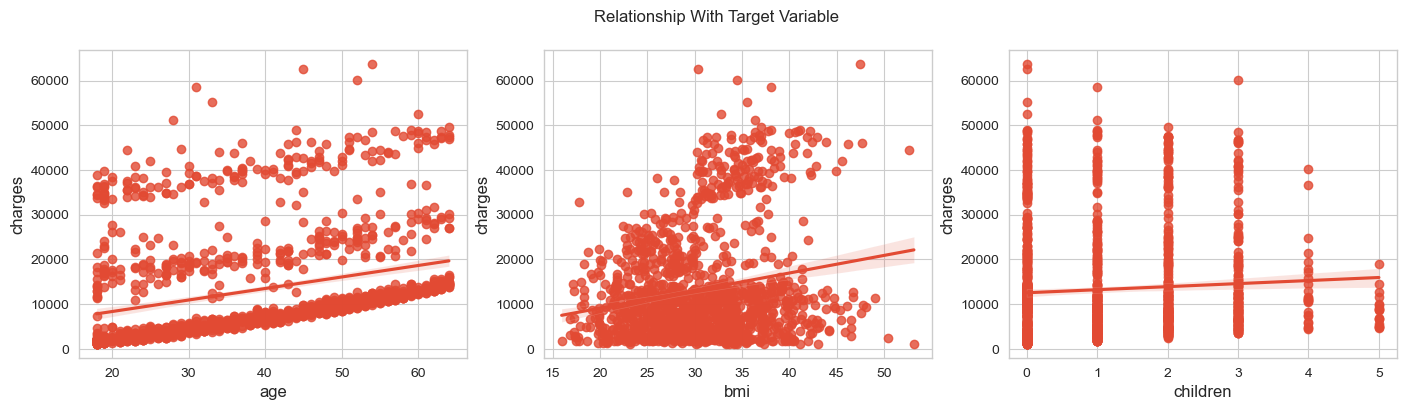

In [19]:
plot_relationship(df, num, 'charges')

- As seen in the correlation matrix, charges tends to increase with all numerical variables.

## Hypothesis Testing w/ statsmodels

### Data Preprocessing

In [20]:
# Encoding of binary variables
df['smoker'] = np.where(df['smoker'] == 'yes', 1, 0)
df['sex'] = np.where(df['sex'] == 'male', 1, 0)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['charges']), 
    df['charges'], 
    test_size=0.2, 
    random_state=42
)

In [22]:
# Mean target encoding 'region' variable
encoder = ce.MeanEncoder(variables=['region'])
encoder.fit(X_train, y_train)            # Fitting with train data to prevent data leakage

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [23]:
# Standardization
scaler = StandardScaler()
scaler.fit(X_train)     # Fitting with train data to prevent data leakage

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# Adding a column for the constant
X_train = sm.add_constant(X_train)

# Running the model
results = sm.OLS(y_train, X_train).fit()

In [25]:
# Summary of our regression:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     507.1
Date:                Wed, 23 Nov 2022   Prob (F-statistic):          9.56e-308
Time:                        11:49:53   Log-Likelihood:                -10847.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1063   BIC:                         2.174e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.335e+04    187.496     71.181      0.000     1.3e+04    1.37e+04
x1          3615.5401    189.646     19.065      0.000    3243.417    3987.663
x2            -4.2139    188.041     -0.022      0.982    -373.188     364.760
x3          1982.1220    193.310     10.254      0.000    1602.810    2361.434
x4           518.8636    187.976      2.760      0.006     150.017     887.711
x5          9560.5981    188.582     50.697      0.000    9190.563    9930.633
x6           -16.9636    192.371     -0.088      0.930    -394.433     360.506
==============================================================================
Omnibus:                      254.125   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              619.813
Skew:                           1.260   Prob(JB):                    2.57e-135
Kurtosis:                       5.747   Cond. No.                         1.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- F-Statistic from model summary provides information about hypothesis test of the relationship between 'Charges' and predictors. Generally speaking, if none of your independent variables are statistically significant, the overall F-test is also not statistically significant.
    - Null hypothesis: All coefficients are zero.
    - Alternative hypothesis: At least one coefficient is non-zero.
- Since F-Stat. > 1 and the p-value associated with it is pretty close to zero, the null hypothesis is rejected and it is proved that at least one predictor has a relationship with the response!
- Two predictors presented high p-value and we can infer that there is very little association between them and the predictor. Therefore 'sex' and 'region' will be removed from the regression because of its statistical insignificance.

## Testing Assumptions of Linear Regression
- It is important to check violations to the assumptions because the results of our linear regression may be unreliable.
### Linearity Assumption
- The most obvious is this one. Linear regression assumes that there is a linear relationship between the independent variables and the dependent one (Y).

<AxesSubplot:title={'center':'Residuals vs Fitted'}, xlabel='Fitted values', ylabel='Residuals'>

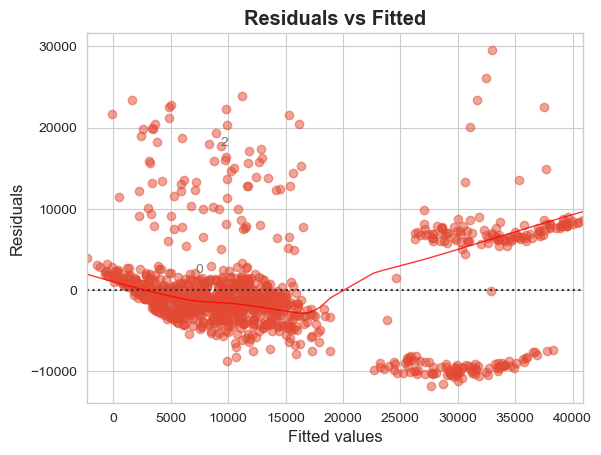

In [26]:
# For this we are going to use Prajwal Kafle's contribution to statsmodels documentation (Linear regression diagnostics)
cls = lrd(results)
cls.residual_plot()

- Residual plots is a graphical tool used for identifying non-linearity between predictors and response. Since there is no obvious pattern in the red line, it suggests a linear association in our data.

### Independence of observations Assumption
- Means that there is no relatin between the different examples. 
- Since this is mostly correlated to the data collection process and likely to occur using time series, we will assume that there is no dependence between observations.

### Normality Assumption
- The residuals should follow a normal distribution since the coefficients' probability distributions rely on it. So this assumption is important for hypothesis tests, but its violation is only a problem with small samples (since central limit theorem, F-tests and t-tests are robust to normality deviations).

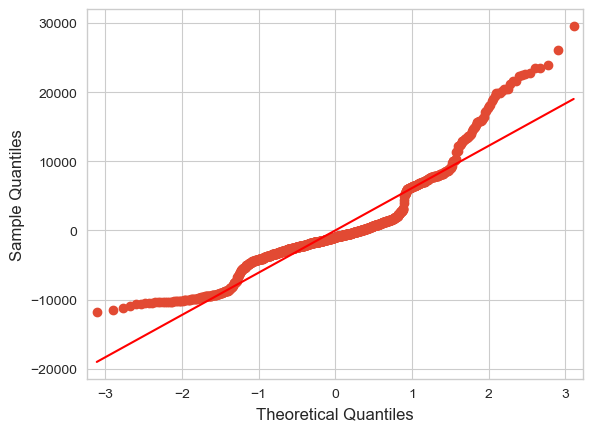

In [27]:
qqplot = sm.qqplot(results.resid, line='s')

- Q-Q plot assesses the normality of residuals distribution. From it we can see that the normality assumption of linear regression models has been violated.

### Homoscedasticity Assumption

- Homoscedasticity in a model means that the error is constant along the values of the dependent variables (residuals have constant variance at every level of X).
- When there is heteroscedasticity, it increases the variance of the regression coefficient estimates. It makes much more likely for a regression model to declare statistical significance for a term that in fact is not.

In [28]:
name = ["Lagrange multiplier statistic", "p-value", "f-value"]
test = sms.het_breuschpagan(results.resid, results.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 88.96247860485053),
 ('p-value', 4.9760840627600896e-17),
 ('f-value', 16.06583382296303)]

- From Breusch-Pagan Lagrange Multiplier test we can prove that the residuals have a constant variance. This is important because confidence intervals and hypothesis tests rely upon this assumption.

### No/Little Multicollinearity Assumption
- Multicollinearity is the phenomenon when a number of the explanatory variables are strongly correlated.

In [29]:
# Lets compute the variance inflation factor to assess multicollinearity. VIF > 10 indicates a problematic amount of collinearity!
#gather features
features = "+".join(df[num].columns)

# get y and X dataframes based on this regression:
y, X = dmatrices('charges ~' + features, df, return_type='dataframe')

In [30]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Val"] = [VIF(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [31]:
vif.sort_values(by='VIF_Val', ascending=False).iloc[1:,:]

,VIF_Val,features
1,1.013816,age
2,1.012152,bmi
3,1.001874,children


- There is no multicollinearity since all variance inflation factors are bellow 5.